<a href="https://colab.research.google.com/github/puneet-08/projects/blob/main/FaceNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Face Recognition using FaceNet

Face Recognition is a method to identify an individual from a photograph. 
FaceNet is one of the techniques proposed by Google Researchers in 2015 in the paper titled [FaceNet: A Unified Embedding for Face Recognition and Clustering](https://arxiv.org/abs/1503.03832).

FaceNet employs a deep Convolutional Network which outputs an embedding of 128 elements. This embedding vector contains all the information which helps in perfoming the task.

In [16]:
#Importing the required libraries

!pip install mtcnn
!pip install tensorflow-addons

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import mtcnn
import os
import zipfile
from mtcnn.mtcnn import MTCNN
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

**Model Architechture**



Images are sent to a deep convolutional neural network. This CNN containes inception modules in blocks to reduce the number of trainable parameters. The output of this neural network is a 128 dimensional embedding vector. 

The main difference between FaceNet and other techniques is that it learns the mapping from the images and creates embeddings rather than using any bottleneck layer for recognition or verification tasks.

The network is trained such that L2 distance of the similar faces is low and that of dis-simlar faces is large. In order to follow this strategy the model is trained via **triplet loss function**  that encourages vectors for the same identity to become more similar (smaller distance), whereas vectors for different identities are expected to become less similar (larger distance). 

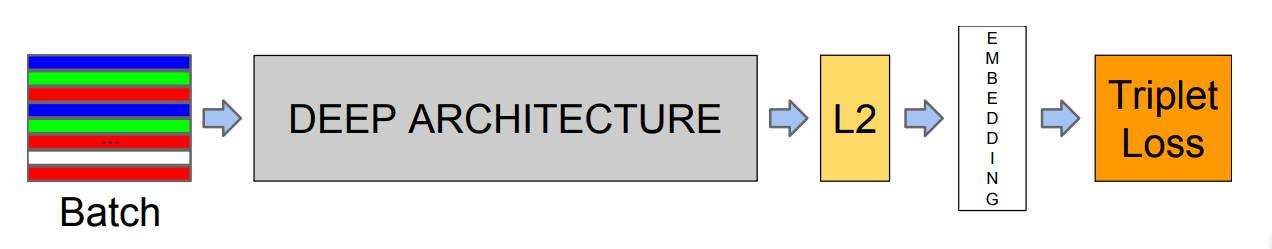

**Triplet Loss Function**

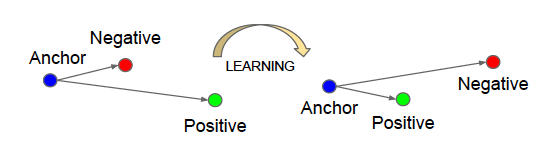

The intution behind triplet loss is that we want to learn embeddings such that -
the distance between anchor image (a random image of person A) and positive images (all the other images of person A in the training dataset) to be low AND the distance between anchor image and negative images (all the images of remaining people in the training dataset) to be high.
We need a triplet of images (anchor, positive and negative)in one training example, hence triplet loss.

Triplet loss is calculated by -

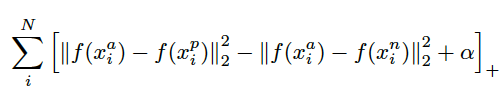

This formula says that the "*elucidian distance between anchor image and positive image*" to be **greater by some margin alpha** than "*the elucidian distance between anchor and negative image*".

If alpha is 0.5, then we want the difference between our anchor-positive image pair and anchor-negative image pair to be at least 0.5.

Therefore choosing the correct Anchor, Positive and Negative triplets becomes extremely important. If we choose these randomly, the model will not be robust. The best strategy is to find Anchor and Positive pairs such that L2 distance is largest, and Anchor and Negative pairs such that L2 distance is smallest; which is completly opposite of optimization we are aiming for in the triplet loss. This will ensure that our model is able to diffrentiate between similar looking people like twins.

For this notebook we are going to download a pretrained model provided by [Hiroki Taniai](https://github.com/nyoki-mtl) trained on [MS-Celeb-1M dataset](https://www.microsoft.com/en-us/research/project/ms-celeb-1m-challenge-recognizing-one-million-celebrities-real-world/).

In [17]:
#Loading the model and pre-trained weights

model = load_model('/content/facenet_keras.h5')
model.load_weights('/content/facenet_keras_weights.h5')
model.summary()

Model: "inception_resnet_v1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv2d_1a_3x3 (Conv2D)         (None, 79, 79, 32)   864         ['input_1[0][0]']                
                                                                                                  
 Conv2d_1a_3x3_BatchNorm (Batch  (None, 79, 79, 32)  96          ['Conv2d_1a_3x3[0][0]']          
 Normalization)                                                                                   
                                                                                

In [ ]:
# model.compile(optimizer = tf.keras.optimizers.Adam(0.0001),
#               loss = tfa.losses.TripletSemiHardLoss())

The [5 Celebrity Faces Dataset](https://github.com/nyoki-mtl/keras-facenet) is a small dataset that contains photographs of celebrities.

It includes photos of: Ben Affleck, Elton John, Jerry Seinfeld, Madonna, and Mindy Kaling.

The dataset is downloaded from kaggle.

Loading training and validation data-

In [10]:
zipfile.ZipFile('/content/archive.zip', 'r').extractall()

In [11]:
train_ben = os.path.join("/content/train/ben_afflek")
train_elton = os.path.join("/content/train/elton_john")
train_jerry = os.path.join("/content/train/jerry_seinfeld")
train_madonna = os.path.join("/content/train/madonna")
train_mindy = os.path.join("/content/train/mindy_kaling")

val_ben = os.path.join("/content/val/ben_afflek")
val_elton = os.path.join("/content/val/elton_john")
val_jerry = os.path.join("/content/val/jerry_seinfeld")
val_madonna = os.path.join("/content/val/madonna")
val_mindy = os.path.join("/content/val/mindy_kaling")

print('number of training ben examples:', len(os.listdir(train_ben)))
print('number of training elton examples:', len(os.listdir(train_elton)))
print('number of training jerry examples:', len(os.listdir(train_jerry)))
print('number of training madonna examples:', len(os.listdir(train_madonna)))
print('number of training mindy examples:', len(os.listdir(train_mindy)))


print('number of val ben examples:', len(os.listdir(val_ben)))
print('number of val elton examples:', len(os.listdir(val_elton)))
print('number of val jerry examples:', len(os.listdir(val_jerry)))
print('number of val madonna examples:', len(os.listdir(val_madonna)))
print('number of val mindy examples:', len(os.listdir(val_mindy)))

number of training ben examples: 14
number of training elton examples: 17
number of training jerry examples: 21
number of training madonna examples: 19
number of training mindy examples: 22
number of val ben examples: 5
number of val elton examples: 5
number of val jerry examples: 5
number of val madonna examples: 5
number of val mindy examples: 5


In [12]:
index = 2

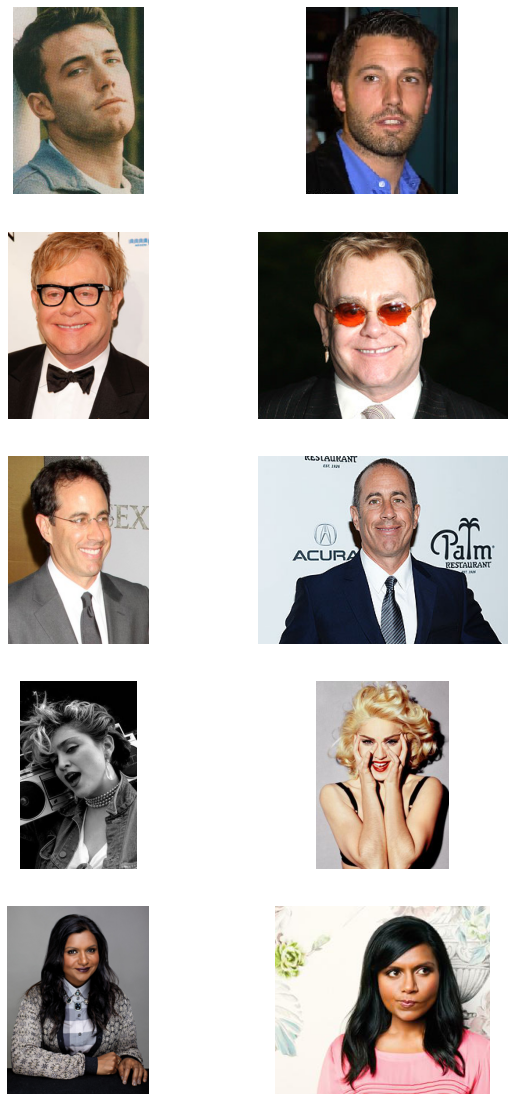

In [18]:
#Plotting a couple of the training images for each celeb

files_train_ben = [os.path.join(train_ben, image) for image in os.listdir(train_ben)]
files_train_elton = [os.path.join(train_elton, image) for image in os.listdir(train_elton)]
files_train_jerry = [os.path.join(train_jerry, image) for image in os.listdir(train_jerry)]
files_train_madonna = [os.path.join(train_madonna, image) for image in os.listdir(train_madonna)]
files_train_mindy = [os.path.join(train_mindy, image) for image in os.listdir(train_mindy)]

files_val_ben = [os.path.join(val_ben, image) for image in os.listdir(val_ben)]
files_val_elton = [os.path.join(val_elton, image) for image in os.listdir(val_elton)]
files_val_jerry = [os.path.join(val_jerry, image) for image in os.listdir(val_jerry)]
files_val_madonna = [os.path.join(val_madonna, image) for image in os.listdir(val_madonna)]
files_val_mindy = [os.path.join(val_mindy, image) for image in os.listdir(val_mindy)]

index += 2
                                                              
images = files_train_ben[index-2:index] + files_train_elton[index-2:index] + \
         files_train_jerry[index-2:index] + files_train_madonna[index-2:index] + \
         files_train_mindy[index-2:index]

plt.figure(figsize = (10,20))

for i,image in enumerate(images):
  plt.subplot(5,2,i+1)
  plt.axis('Off')
  img = mpimg.imread(image)
  plt.imshow(img)
plt.show()


In [19]:
# Function to normalize the image array
def normalize(img):
  mean, std = img.mean(), img.std()
  return (img - mean)/std

Next we need to extract faces of the individuals from the images. The process of extracting face is called as Face detection. In this notebook, we will also use the **Multi-Task Cascaded Convolutional Neural Network, or MTCNN**, for face detection, e.g. finding and extracting faces from photos.

In [20]:
# Function to extract faces 
def extract_face(image, required_shape = (160, 160)):

  img_BGR = cv2.imread(image) #reads image in BGR format. needs to be converted
  img_RGB = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2RGB)

  detector = MTCNN()
  x = detector.detect_faces(img_RGB)
  x1, y1, width, height = x[0]['box']
  x1, y1 = abs(x1), abs(y1)
  x2, y2 = x1 + width, y1 + height

  face = img_RGB[y1:y2 , x1:x2]

  face = face.astype('float')
  face = normalize(face)
  face = cv2.resize(face, required_shape)
  face = np.expand_dims(face, axis = 0)

  return face

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


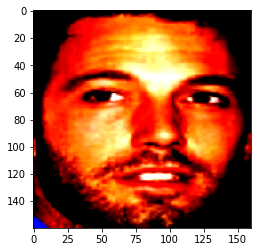

In [21]:
#Testing if the function works
plt.imshow(extract_face(files_train_ben[5])[0])

In [22]:
# Creating embeddings for all of the training data
training = [files_train_ben, files_train_elton, files_train_jerry, files_train_madonna, files_train_mindy]
encoding= []
for celebs in training:
  encoding_inner = []
  for img in celebs:
    face = extract_face(img)
    encoding_inner.append(model.predict(face)[0])
  encoding.append(encoding_inner)

In [23]:
# Taking mean of the all of the embeddings so that we have a single unique embedding per person. 
ben = np.mean(encoding[0], axis =0)
elton =np.mean(encoding[1], axis =0)
jerry = np.mean(encoding[2], axis =0)
madonna = np.mean(encoding[3], axis =0)
mindy = np.mean(encoding[4], axis = 0)
final_encodings = [ben, elton, jerry, madonna, mindy]

In [24]:
final_encodings

[array([ 1.3054856e-02,  7.6700634e-01, -7.6667356e-01, -9.5941544e-01,
         2.4220386e-01, -5.7197756e-01,  8.9062035e-01, -3.6000258e-01,
         2.5088722e-01, -6.5232265e-01,  8.3683747e-01, -5.7233524e-01,
         1.7420454e-01, -6.4800376e-01,  8.1307131e-01, -1.0582181e-01,
        -1.6860315e+00, -7.4886322e-02, -4.4712070e-01, -3.0310601e-02,
         1.3735510e+00,  1.3737282e-01,  2.2456888e-02, -1.0358057e-01,
         7.1978465e-02, -4.1209221e-01,  5.2203614e-01, -1.0968179e+00,
        -6.8552011e-01,  6.1158818e-01, -2.9811195e-01,  8.0948508e-01,
         1.3041540e+00,  5.5471200e-01, -6.6863811e-01,  8.3706707e-01,
        -1.5940411e+00, -7.1697062e-01, -1.4193623e+00, -2.0385841e-01,
         1.0135270e+00, -1.9966398e-01, -3.2422525e-01,  9.1349602e-02,
        -6.3061498e-02, -6.2147743e-01,  8.6248600e-01,  8.0140814e-02,
        -1.5762001e-03,  1.5972434e-01, -8.3671290e-01, -5.1388448e-01,
         2.2404577e-01, -8.2829767e-01,  6.2293297e-01, -1.02169

In [25]:
model.predict(extract_face(files_train_ben[5])).shape

(1, 128)

**Predicting Identity**

We are going to employ a simple crude techniqe for prediction -

*   We are going to calculate embedding of the input image.
*   Then we are going to calculate the L2 distance of the input image from each of the five distinct embeddings for the celebs.
*   If the distance is greater than a certain threshold we ar going to predict 'person is not in the dataset'.
*   If the distance is less than a certain threshold, we predict the identity for which L2 distance is lowest.

**Now the question is how do we calculate threshold?**

For this, we are going to start with a random guess. Test this method for all of the training dataset. Then select the threshold value more than the highest min distance we obtain during the training.



In [26]:
# Writing a funciton to find the identity given an image
def who_is_it(image_path, final_encodings, model):
  identity = ['ben','elton', 'jerry','madonna','mindy']
  encoding = model.predict(extract_face(image_path))[0]
  max_dis = 10000000
  threshold = 12
  dist = []
  for i in final_encodings:
    dist_ = np.linalg.norm(i-encoding)
    dist.append(dist_)

  min_dist = min(dist) 
  if min_dist > threshold:
    print('Person is not in the database. Min Dist :', min_dist)
    plt.axis('Off')
    plt.imshow(extract_face(image_path)[0])
    plt.show()
  else:
    mask = np.argmin(dist)
    print('Identity of the person is  :', identity[mask], "   Min dist :", min_dist)
    plt.axis('Off')
    plt.imshow(extract_face(image_path)[0])
    plt.show()

Identity of the person is  : ben    Min dist : 8.9823265


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


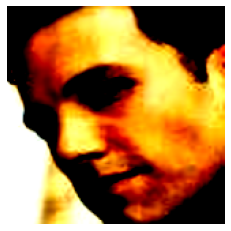

Identity of the person is  : ben    Min dist : 5.956979


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


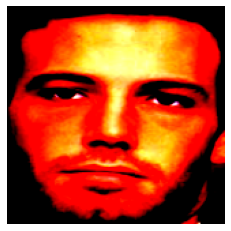

Identity of the person is  : ben    Min dist : 8.200593


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


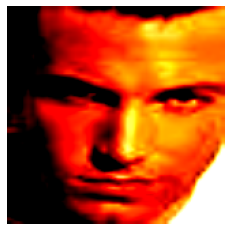

Identity of the person is  : ben    Min dist : 6.189007


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


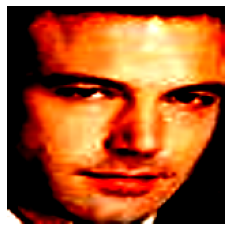

Identity of the person is  : ben    Min dist : 9.134869


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


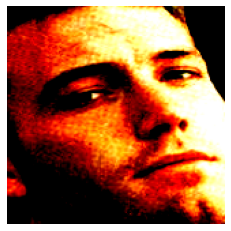

Identity of the person is  : ben    Min dist : 6.4692984


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


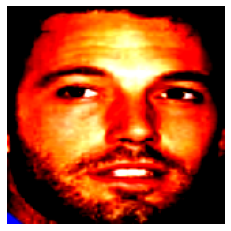

Identity of the person is  : ben    Min dist : 5.552916


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


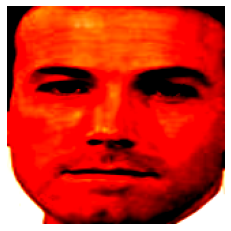

Identity of the person is  : ben    Min dist : 8.116491


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


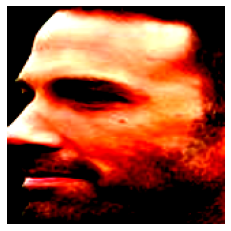

Identity of the person is  : ben    Min dist : 6.8893805


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


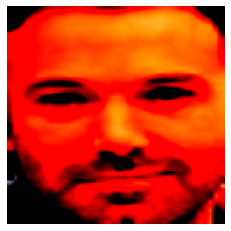

Identity of the person is  : ben    Min dist : 7.0296135


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


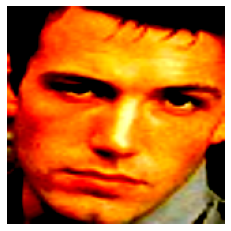

Identity of the person is  : ben    Min dist : 5.859119


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


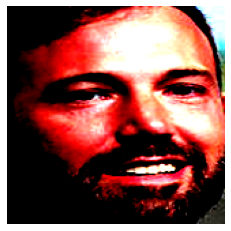

Identity of the person is  : ben    Min dist : 10.339933


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


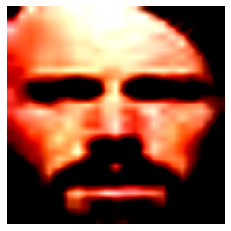

Identity of the person is  : ben    Min dist : 7.739059


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


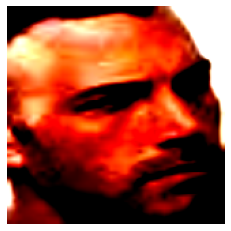

Identity of the person is  : ben    Min dist : 6.652508


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


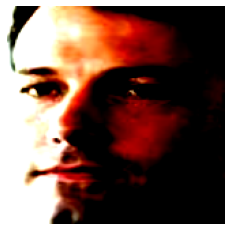

Identity of the person is  : elton    Min dist : 8.813671


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


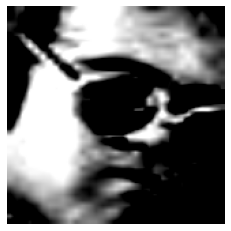

Identity of the person is  : elton    Min dist : 9.541727


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


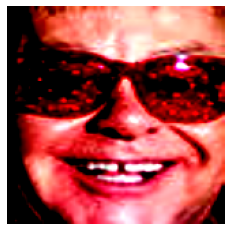

Identity of the person is  : elton    Min dist : 10.159762


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


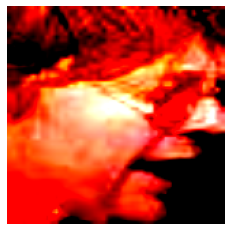

Identity of the person is  : elton    Min dist : 10.00854


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


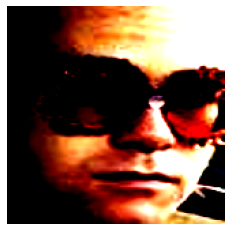

Identity of the person is  : elton    Min dist : 5.9205084


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


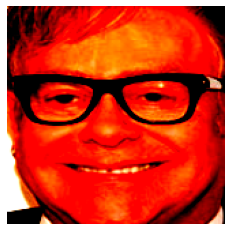

Identity of the person is  : elton    Min dist : 6.1545815


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


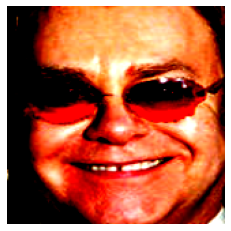

Identity of the person is  : elton    Min dist : 9.000612


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


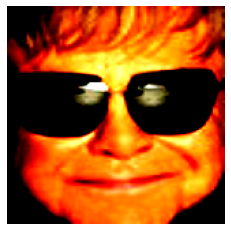

Identity of the person is  : elton    Min dist : 9.773655


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


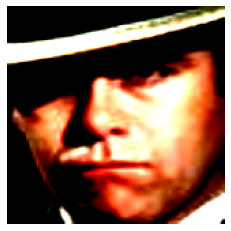

Identity of the person is  : elton    Min dist : 7.673845


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


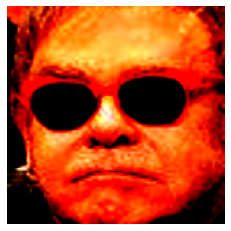

Identity of the person is  : elton    Min dist : 8.285256


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


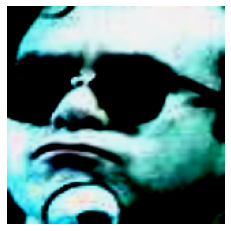

Identity of the person is  : elton    Min dist : 8.583532


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


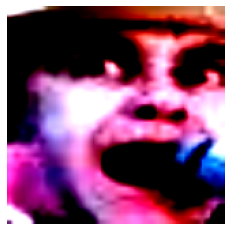

Identity of the person is  : elton    Min dist : 9.177133


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


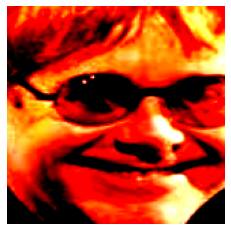

Identity of the person is  : elton    Min dist : 6.276265


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


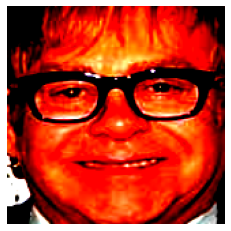

Identity of the person is  : elton    Min dist : 9.75517


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


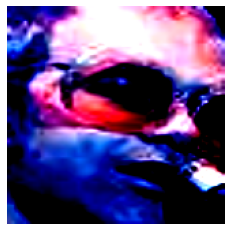

Identity of the person is  : elton    Min dist : 8.273312


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


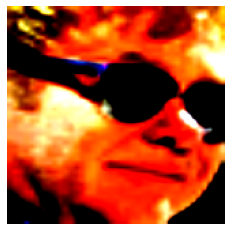

Identity of the person is  : elton    Min dist : 11.559634


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


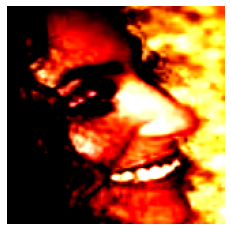

Identity of the person is  : elton    Min dist : 6.1325417


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


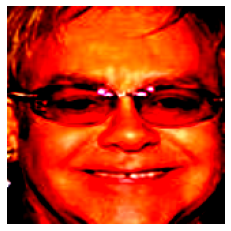

Identity of the person is  : jerry    Min dist : 5.024824


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


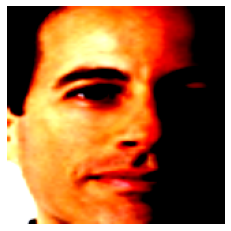

Identity of the person is  : jerry    Min dist : 5.185306


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


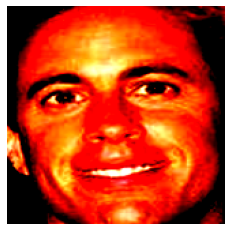

Identity of the person is  : jerry    Min dist : 4.970262


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


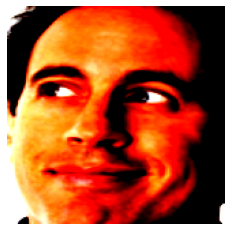

Identity of the person is  : jerry    Min dist : 7.4047074


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


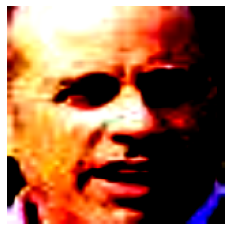

Identity of the person is  : jerry    Min dist : 6.762112


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


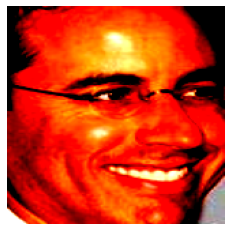

Identity of the person is  : jerry    Min dist : 4.829015


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


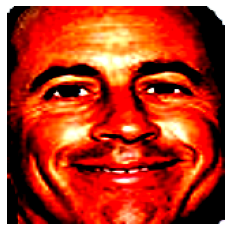

Identity of the person is  : jerry    Min dist : 5.297366


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


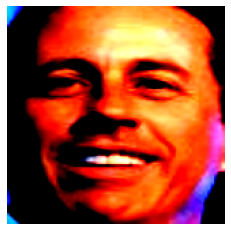

Identity of the person is  : jerry    Min dist : 4.0028644


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


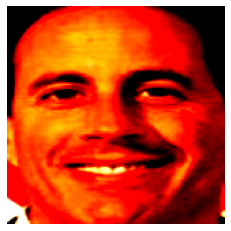

Identity of the person is  : jerry    Min dist : 5.341958


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


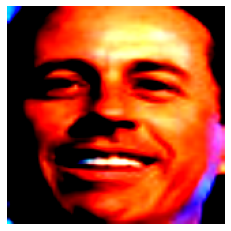

Identity of the person is  : jerry    Min dist : 4.9898953


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


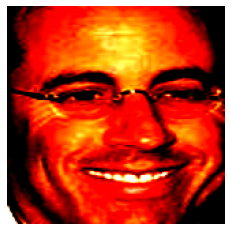

Identity of the person is  : jerry    Min dist : 5.640309


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


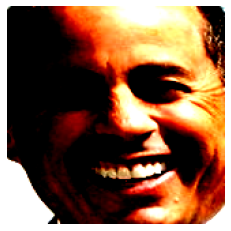

Identity of the person is  : jerry    Min dist : 4.0583205


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


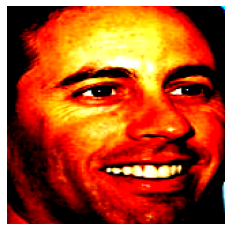

Identity of the person is  : jerry    Min dist : 5.679562


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


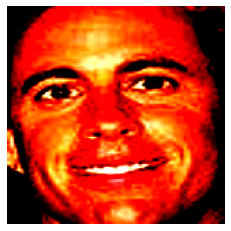

Identity of the person is  : jerry    Min dist : 4.6433134


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


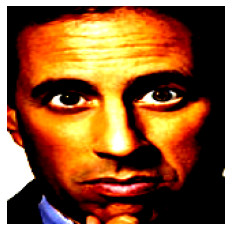

Identity of the person is  : jerry    Min dist : 4.4744973


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


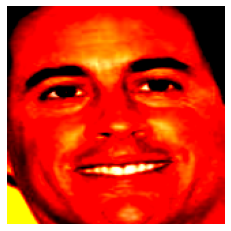

Identity of the person is  : jerry    Min dist : 3.5947587


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


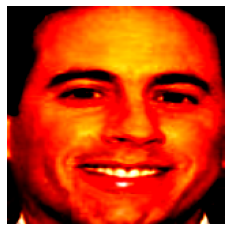

Identity of the person is  : jerry    Min dist : 6.560277


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


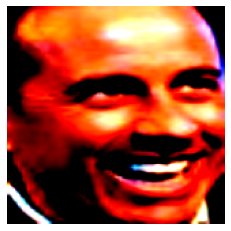

Identity of the person is  : jerry    Min dist : 6.2388496


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


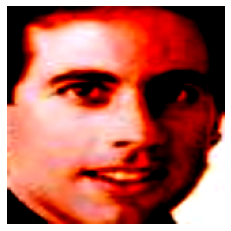

Identity of the person is  : jerry    Min dist : 6.1353755


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


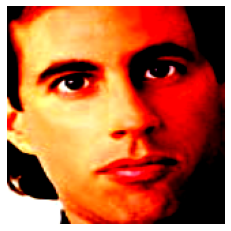

Identity of the person is  : jerry    Min dist : 5.985306


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


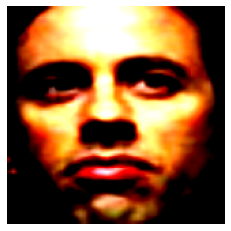

Identity of the person is  : jerry    Min dist : 6.5100865


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


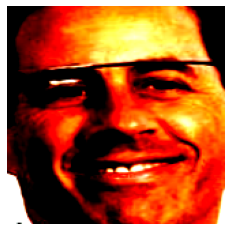

Identity of the person is  : madonna    Min dist : 8.735252


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


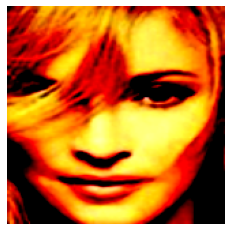

Identity of the person is  : madonna    Min dist : 7.34094


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


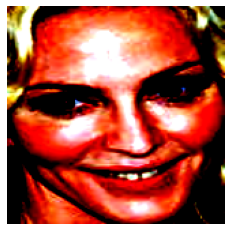

Identity of the person is  : madonna    Min dist : 7.8343143


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


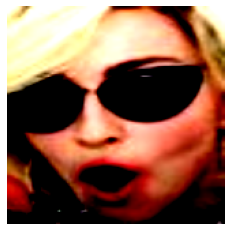

Identity of the person is  : madonna    Min dist : 6.648461


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


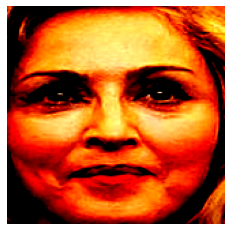

Identity of the person is  : madonna    Min dist : 10.031932


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


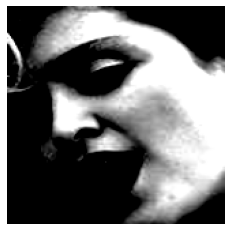

Identity of the person is  : madonna    Min dist : 9.161598


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


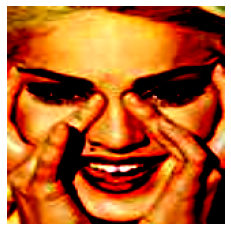

Identity of the person is  : madonna    Min dist : 10.377823


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


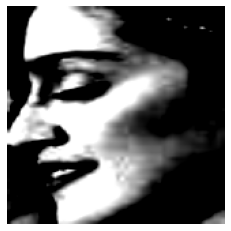

Identity of the person is  : madonna    Min dist : 7.53517


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


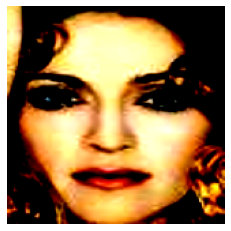

Identity of the person is  : madonna    Min dist : 7.1346693


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


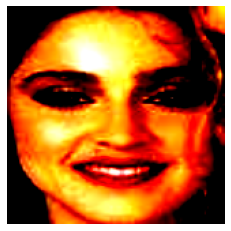

Identity of the person is  : madonna    Min dist : 7.8176203


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


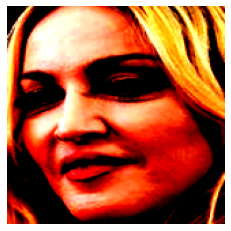

Identity of the person is  : madonna    Min dist : 7.5238924


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


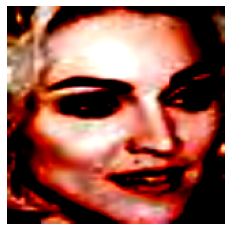

Identity of the person is  : madonna    Min dist : 8.719891


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


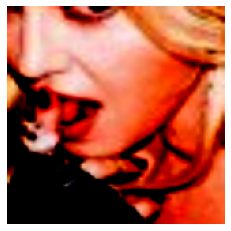

Identity of the person is  : madonna    Min dist : 7.610399


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


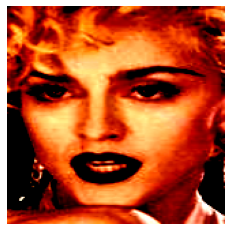

Identity of the person is  : madonna    Min dist : 5.880315


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


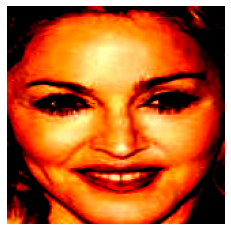

Identity of the person is  : madonna    Min dist : 7.119846


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


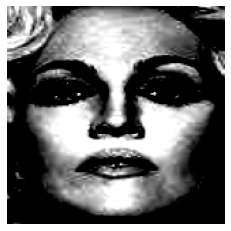

Identity of the person is  : madonna    Min dist : 8.591246


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


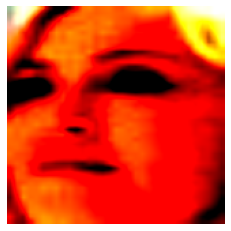

Identity of the person is  : madonna    Min dist : 9.775163


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


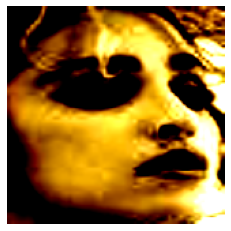

Identity of the person is  : madonna    Min dist : 7.962572


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


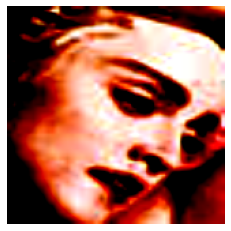

Identity of the person is  : madonna    Min dist : 7.2358994


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


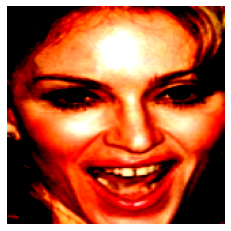

Identity of the person is  : mindy    Min dist : 6.7860346


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


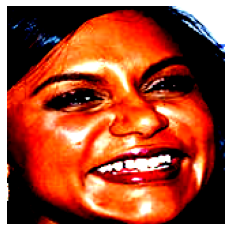

Identity of the person is  : mindy    Min dist : 8.543425


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


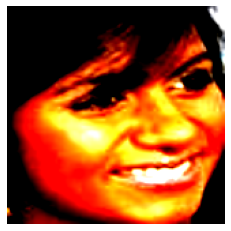

Identity of the person is  : mindy    Min dist : 5.091319


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


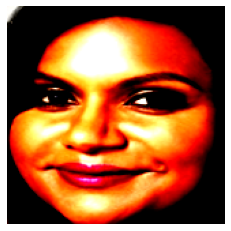

Identity of the person is  : mindy    Min dist : 4.9663634


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


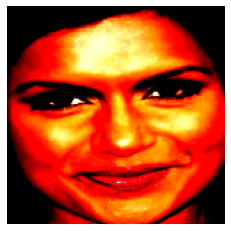

Identity of the person is  : mindy    Min dist : 5.818149


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


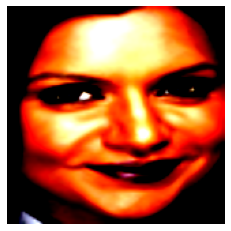

Identity of the person is  : mindy    Min dist : 5.533521


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


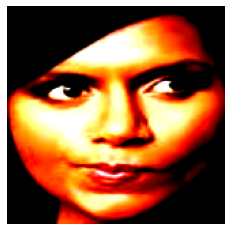

Identity of the person is  : mindy    Min dist : 7.361921


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


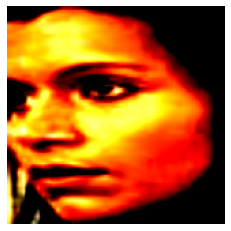

Identity of the person is  : mindy    Min dist : 4.8376994


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


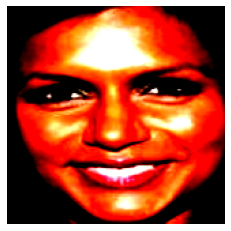

Identity of the person is  : mindy    Min dist : 6.556443


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


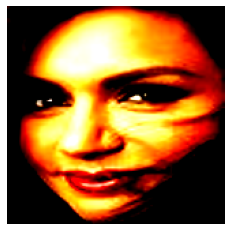

Identity of the person is  : mindy    Min dist : 5.199833


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


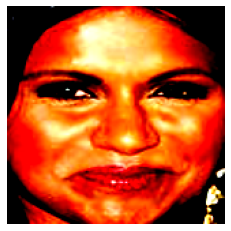

Identity of the person is  : mindy    Min dist : 4.7091737


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


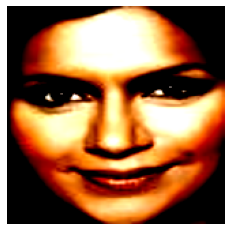

Identity of the person is  : mindy    Min dist : 4.7018843


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


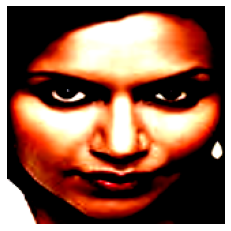

Identity of the person is  : mindy    Min dist : 8.086182


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


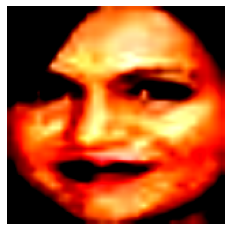

Identity of the person is  : mindy    Min dist : 4.6637106


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


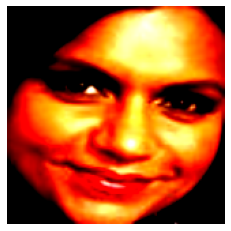

Identity of the person is  : mindy    Min dist : 11.223824


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


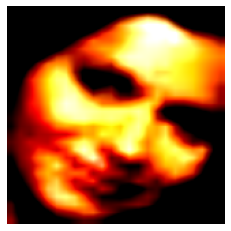

Identity of the person is  : mindy    Min dist : 5.135575


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


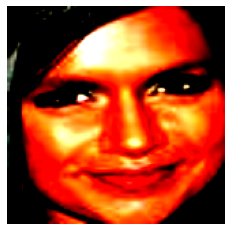

Identity of the person is  : mindy    Min dist : 7.1261573


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


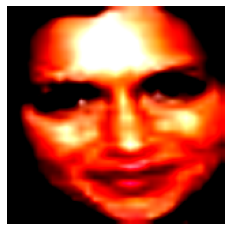

Identity of the person is  : mindy    Min dist : 6.18607


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


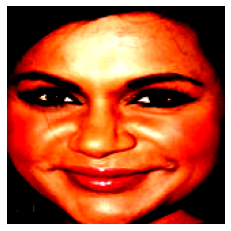

Identity of the person is  : mindy    Min dist : 4.607275


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


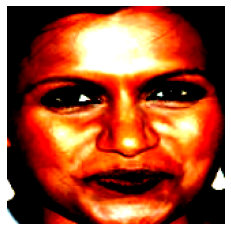

Identity of the person is  : mindy    Min dist : 8.202659


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


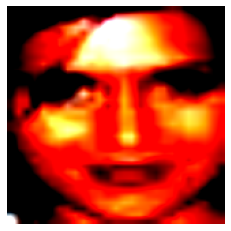

Identity of the person is  : mindy    Min dist : 4.4808764


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


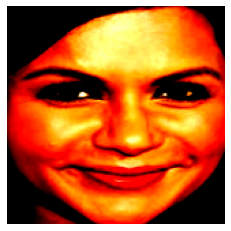

Identity of the person is  : mindy    Min dist : 8.725389


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


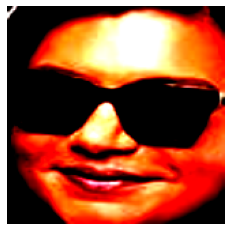

In [27]:
train_images = files_train_ben + files_train_elton + files_train_jerry + files_train_madonna + files_train_mindy
for image in train_images:
  who_is_it(image, final_encodings, model)

The maximum min distance is 11.22 for an image of Mindy. We are going to use 12 as threshold in the 'who_is_it' function.

In [ ]:
#Now predicting on the val dataset

val_images = files_val_ben + files_val_elton + files_val_jerry + files_val_madonna + files_val_mindy

for image in val_images:
  who_is_it(image, final_encodings, model)


In this notebook we have used a crude way to calculate the threshold and hence predict the identity. However, it does a pretty good job on our validation dataset. We can also use machine learning algorithms like SVM, feed in the learned embeddings as inputs, and tackle it like a multi-class classificaton problem.

**References**

*   https://arxiv.org/abs/1503.03832
*   https://machinelearningmastery.com/how-to-develop-a-face-recognition-system-using-facenet-in-keras-and-an-svm-classifier/
*   https://github.com/nyoki-mtl/keras-facenet


